In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Neural Network Model

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_sigmoid_stack = nn.Sequential(
        nn.Linear(1,10),
        nn.Sigmoid(),
        nn.Linear(10,1, bias=False)
        )
        
    def forward_propagation(self, x):
        N = self.linear_sigmoid_stack(x)
        return N

In [3]:
def training(x, loss_fn, optimizer):
    x = x.to(device)
    def closure():
        loss = loss_fn(x)
        optimizer.zero_grad()
        loss.backward()
        return loss
    optimizer.step(closure)

## Example 1
### Differential equation
$$\frac{d\psi}{dx} + \left(x+\frac{1+3x^2}{1+x+x^3} \right)\psi = x^3+2x+x^2\left(\frac{1+3x^2}{1+x+x^3} \right)$$ 
Dataset are vectors of domain of differential equation, like the vectors are one-dimentional, the shape of dataset is one by m samples. Trial solution $\psi_t(x) = A + xN(x,\vec{p})$, with $\psi(0) = A = 1$ initial condition.  

In [4]:
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=1, bias=False)
  )
)

In [5]:
optimizer = torch.optim.LBFGS(model.parameters())
A = 1
Psi_t = lambda x: A + x * model.forward_propagation(x)
f = lambda x, Psi: x**3 + 2*x + ((1+3*x**2)/(1+x+x**3))*x**2 - (x+(1+3*x**2)/(1+x+x**3))*Psi

In [6]:
def loss_fn(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    return torch.mean((Psi_t_x - f(x, outputs))**2)

In [16]:
upper_x = 20
steps = 100
X_train = torch.Tensor(np.linspace(0,upper_x,steps)[:,None])
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n ---------------------- loss: {loss_fn(X_train.to(device))}")
    training(X_train, loss_fn, optimizer)
print("Done!")

Epoch 1
 ---------------------- loss: 10414964.0
Epoch 2
 ---------------------- loss: 278420.5625
Epoch 3
 ---------------------- loss: 268243.96875
Epoch 4
 ---------------------- loss: 6007.6865234375
Epoch 5
 ---------------------- loss: 4683.30615234375
Epoch 6
 ---------------------- loss: 222.16384887695312
Epoch 7
 ---------------------- loss: 12026.5498046875
Epoch 8
 ---------------------- loss: 144.92445373535156
Epoch 9
 ---------------------- loss: 118.03681182861328
Epoch 10
 ---------------------- loss: 37552.41796875
Epoch 11
 ---------------------- loss: 91.75042724609375
Epoch 12
 ---------------------- loss: 50.607391357421875
Epoch 13
 ---------------------- loss: 39.20899200439453
Epoch 14
 ---------------------- loss: 15.442304611206055
Epoch 15
 ---------------------- loss: 11.878820419311523
Epoch 16
 ---------------------- loss: 8.311993598937988
Epoch 17
 ---------------------- loss: 6.201416969299316
Epoch 18
 ---------------------- loss: 4.189786911010742
Ep

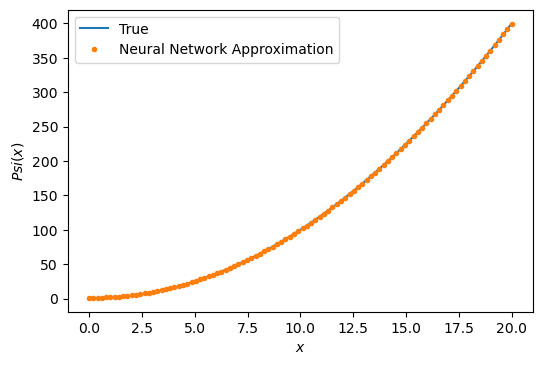

In [17]:
xx = np.linspace(0, upper_x, steps)[:,None]

with torch.no_grad():
    sol = Psi_t(torch.Tensor(xx).to(device)).cpu()
    yy = sol.numpy()
yt = xx**2 + np.exp(-xx**2 / 2)/(1+xx+xx**3)

fig, axs = plt.subplots(dpi=100)
axs.plot(xx, yt, label="True")
axs.plot(xx, yy, ".", label="Neural Network Approximation")
axs.set_xlabel("$x$")
axs.set_ylabel("$Psi(x)$")
plt.legend(loc="best")

In [18]:
score = r2_score(yt, yy)
print(score)
error = yt - yy
print(error)

0.9999956677327884
[[ 0.        ]
 [-0.147035  ]
 [-0.29977036]
 [-0.43851502]
 [-0.54982268]
 [-0.62624941]
 [-0.66874206]
 [-0.68412531]
 [-0.6804518 ]
 [-0.66445648]
 [-0.64107577]
 [-0.61356811]
 [-0.58390443]
 [-0.55327347]
 [-0.52246338]
 [-0.49180146]
 [-0.46156699]
 [-0.43185141]
 [-0.40279339]
 [-0.37436986]
 [-0.34665141]
 [-0.31967561]
 [-0.29351528]
 [-0.26806072]
 [-0.24344201]
 [-0.2196574 ]
 [-0.19668975]
 [-0.17464973]
 [-0.15330846]
 [-0.13302642]
 [-0.11357475]
 [-0.09495724]
 [-0.07734557]
 [-0.06065581]
 [-0.04475825]
 [-0.02987035]
 [-0.01590436]
 [-0.00287172]
 [ 0.00921231]
 [ 0.02045454]
 [ 0.03079011]
 [ 0.04020377]
 [ 0.04869171]
 [ 0.056376  ]
 [ 0.06311167]
 [ 0.06898265]
 [ 0.07403472]
 [ 0.07827551]
 [ 0.08162108]
 [ 0.0842393 ]
 [ 0.08610727]
 [ 0.08725551]
 [ 0.08758483]
 [ 0.08727835]
 [ 0.08633606]
 [ 0.08460537]
 [ 0.0823228 ]
 [ 0.07961041]
 [ 0.07632325]
 [ 0.07233925]
 [ 0.06796359]
 [ 0.06321151]
 [ 0.05811354]
 [ 0.05247132]
 [ 0.04651372]
 [ 0.0

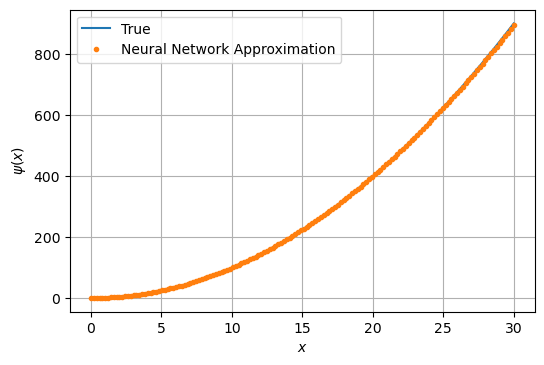

In [19]:
xxx = np.linspace(0, int(upper_x*1.5), int(steps*1.5))[:,None]
with torch.no_grad():
    yyy = Psi_t(torch.Tensor(xxx).to(device)).cpu().numpy()
yyt = xxx**2 + np.exp(-xxx**2 / 2)/(1+xxx+xxx**3)

fig, axs = plt.subplots(dpi=100)
axs.plot(xxx, yyt, label="True")
axs.plot(xxx, yyy, ".", label="Neural Network Approximation")
axs.set_xlabel("$x$")
axs.set_ylabel("$\psi(x)$")
plt.grid()
plt.legend(loc="best")

In [20]:
score = r2_score(yyt, yyy)
print(score)
error = yyt - yyy
print(error)

0.9999625693588395
[[ 0.00000000e+00]
 [-1.46562006e-01]
 [-2.98771860e-01]
 [-4.37234786e-01]
 [-5.48558391e-01]
 [-6.25260678e-01]
 [-6.68192257e-01]
 [-6.84028783e-01]
 [-6.80735488e-01]
 [-6.65070029e-01]
 [-6.41952038e-01]
 [-6.14617146e-01]
 [-5.85117604e-01]
 [-5.54623155e-01]
 [-5.23908889e-01]
 [-4.93350984e-01]
 [-4.63187565e-01]
 [-4.33534564e-01]
 [-4.04502587e-01]
 [-3.76155208e-01]
 [-3.48509104e-01]
 [-3.21541047e-01]
 [-2.95338261e-01]
 [-2.69974210e-01]
 [-2.45374907e-01]
 [-2.21599635e-01]
 [-1.98638915e-01]
 [-1.76553804e-01]
 [-1.55245128e-01]
 [-1.34949399e-01]
 [-1.15426292e-01]
 [-9.69256716e-02]
 [-7.91347312e-02]
 [-6.24044233e-02]
 [-4.65096808e-02]
 [-3.16183505e-02]
 [-1.75931032e-02]
 [-4.49497406e-03]
 [ 7.77903372e-03]
 [ 1.91068499e-02]
 [ 2.94083657e-02]
 [ 3.90345333e-02]
 [ 4.75619215e-02]
 [ 5.52880764e-02]
 [ 6.20756691e-02]
 [ 6.81230638e-02]
 [ 7.33768547e-02]
 [ 7.76691951e-02]
 [ 8.12289670e-02]
 [ 8.39035823e-02]
 [ 8.59371818e-02]
 [ 8.7070365

## Example 3
### Differential equation
$$\frac{d^2\psi}{dx^2} + \frac{1}{5}\frac{d\psi}{dx} + \psi= -\frac{1}{5}e^{-\frac{x}{5}}\cos{(x)}$$ 
Dataset are vectors of domain of differential equation, like the vectors are one-dimentional, the shape of dataset is one by m samples. Trial solution $\psi_t(x) = A + Bx + x^2N(x,\vec{p})$, with $\psi(0) = A = 0$ and $\frac{d\psi}{dx}|_0 = 1$ initial conditions.

In [21]:
model_1= NeuralNetwork().to(device)
model_1

NeuralNetwork(
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=1, bias=False)
  )
)

In [22]:
optimizer = torch.optim.LBFGS(model_1.parameters())
A = 0
B = 1
Psi_t = lambda x: A + B*x + (x**2) * model_1.forward_propagation(x)
f = lambda x, Psi, Psi_x: -(1/5)*torch.exp(-x/5)*torch.cos(x) - Psi - (1/5)*Psi_x

In [23]:
def loss_fn_1(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    Psi_t_x_x = torch.autograd.grad(Psi_t_x, x, grad_outputs=torch.ones_like(Psi_t_x), create_graph=True)[0]
    return torch.mean((Psi_t_x_x- f(x, outputs, Psi_t_x))**2)

In [24]:
upper_x_1 = 5
steps_1 = 100
X_train_1 = torch.Tensor(np.linspace(0,upper_x_1,steps_1)[:,None])
epochs_1 = 50
for t in range(epochs_1):
    print(f"Epoch {t+1}\n ---------------------- loss: {loss_fn_1(X_train_1.to(device))}")
    training(X_train_1, loss_fn_1, optimizer)
print("Done!")

Epoch 1
 ---------------------- loss: 124.39888763427734
Epoch 2
 ---------------------- loss: 0.019370289519429207
Epoch 3
 ---------------------- loss: 0.07824081182479858
Epoch 4
 ---------------------- loss: 0.0020018783397972584
Epoch 5
 ---------------------- loss: 0.0004749665386043489
Epoch 6
 ---------------------- loss: 0.00017102724814321846
Epoch 7
 ---------------------- loss: 6.670680886600167e-05
Epoch 8
 ---------------------- loss: 2.307136674062349e-05
Epoch 9
 ---------------------- loss: 1.730128497001715e-05
Epoch 10
 ---------------------- loss: 1.724166577332653e-05
Epoch 11
 ---------------------- loss: 1.724166577332653e-05
Epoch 12
 ---------------------- loss: 1.724166577332653e-05
Epoch 13
 ---------------------- loss: 1.724166577332653e-05
Epoch 14
 ---------------------- loss: 1.724166577332653e-05
Epoch 15
 ---------------------- loss: 1.724166577332653e-05
Epoch 16
 ---------------------- loss: 1.724166577332653e-05
Epoch 17
 ---------------------- loss:

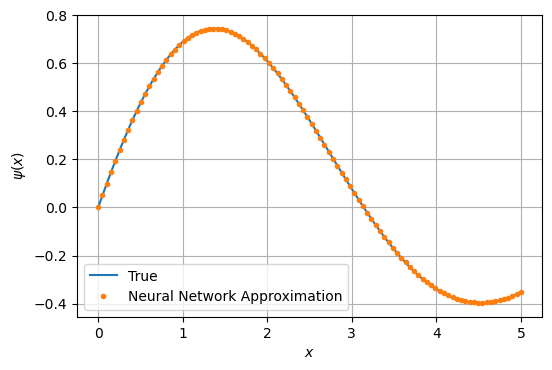

In [25]:
xx = np.linspace(0, upper_x_1, steps_1)[:,None]

with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx).to(device)).cpu().numpy()
yt = yt = np.exp(-xx / 5)*np.sin(xx)

fig, axs = plt.subplots(dpi=100)
axs.plot(xx, yt, label="True")
axs.plot(xx, yy, ".", label="Neural Network Approximation")
axs.set_xlabel("$x$")
axs.set_ylabel("$\psi(x)$")
plt.grid()
plt.legend(loc="best")

In [26]:
score = r2_score(yt, yy)
print(score)
error = yt - yy
print(error)

0.9999954637145911
[[ 0.00000000e+00]
 [-4.01309891e-06]
 [-1.24595869e-05]
 [-2.09629733e-05]
 [-2.62700082e-05]
 [-2.62622077e-05]
 [-1.95975504e-05]
 [-5.73114115e-06]
 [ 1.52775148e-05]
 [ 4.30142448e-05]
 [ 7.64210270e-05]
 [ 1.14115452e-04]
 [ 1.55050814e-04]
 [ 1.97311716e-04]
 [ 2.39515813e-04]
 [ 2.79576830e-04]
 [ 3.16074410e-04]
 [ 3.47850249e-04]
 [ 3.72933648e-04]
 [ 3.91267260e-04]
 [ 4.01398795e-04]
 [ 4.02642846e-04]
 [ 3.95978101e-04]
 [ 3.80581023e-04]
 [ 3.57440698e-04]
 [ 3.26942428e-04]
 [ 2.91328328e-04]
 [ 2.48982173e-04]
 [ 2.04380972e-04]
 [ 1.58666422e-04]
 [ 1.11712110e-04]
 [ 6.82961632e-05]
 [ 2.78760412e-05]
 [-8.65525203e-06]
 [-3.91322997e-05]
 [-6.19538561e-05]
 [-7.41681702e-05]
 [-7.93366209e-05]
 [-7.36441283e-05]
 [-5.66280845e-05]
 [-3.33253531e-05]
 [ 3.11254567e-08]
 [ 4.31361661e-05]
 [ 9.00618328e-05]
 [ 1.45589720e-04]
 [ 2.06140066e-04]
 [ 2.69671289e-04]
 [ 3.31158333e-04]
 [ 3.93810310e-04]
 [ 4.51205272e-04]
 [ 5.06026919e-04]
 [ 5.5375895

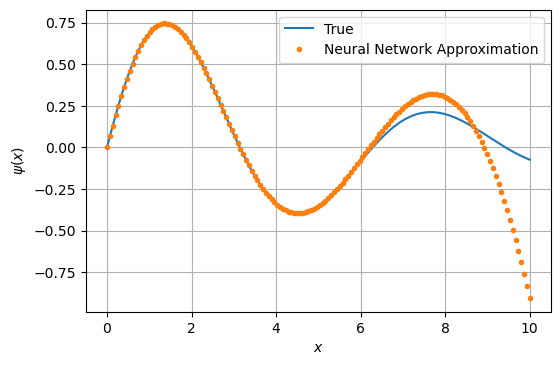

In [27]:
xxx = np.linspace(0,int(upper_x_1*2),int(steps_1*1.5))[:,None]

with torch.no_grad():
    yyy = Psi_t(torch.Tensor(xxx).to(device)).cpu().numpy()
yyt = np.exp(-xxx / 5)*np.sin(xxx)

fig, axs = plt.subplots(dpi=100)
axs.plot(xxx, yyt, label="True")
axs.plot(xxx, yyy, ".", label="Neural Network Approximation")
axs.set_xlabel("$x$")
axs.set_ylabel("$\psi(x)$")
plt.grid()
plt.legend(loc="best")

In [28]:
score = r2_score(yyt, yyy)
print(score)
error = yyt - yyy
print(error)

0.7532408891548705
[[ 0.00000000e+00]
 [-6.54211508e-06]
 [-1.82669404e-05]
 [-2.62345981e-05]
 [-2.49201025e-05]
 [-1.15146761e-05]
 [ 1.46610920e-05]
 [ 5.25952975e-05]
 [ 9.98672720e-05]
 [ 1.53446354e-04]
 [ 2.09652445e-04]
 [ 2.64293591e-04]
 [ 3.14145216e-04]
 [ 3.55273522e-04]
 [ 3.84762591e-04]
 [ 4.00871508e-04]
 [ 4.01923101e-04]
 [ 3.87742882e-04]
 [ 3.59479915e-04]
 [ 3.18290747e-04]
 [ 2.67063213e-04]
 [ 2.08151377e-04]
 [ 1.46961149e-04]
 [ 8.70863205e-05]
 [ 3.25567909e-05]
 [-1.50149824e-05]
 [-5.12116356e-05]
 [-7.27929665e-05]
 [-7.74067429e-05]
 [-6.61758254e-05]
 [-3.80106128e-05]
 [ 8.68200862e-06]
 [ 6.82092509e-05]
 [ 1.38403486e-04]
 [ 2.17136492e-04]
 [ 3.01111298e-04]
 [ 3.83597911e-04]
 [ 4.61011255e-04]
 [ 5.28665550e-04]
 [ 5.84186111e-04]
 [ 6.22131017e-04]
 [ 6.36753449e-04]
 [ 6.27185500e-04]
 [ 5.95509326e-04]
 [ 5.30565414e-04]
 [ 4.40680982e-04]
 [ 3.16349485e-04]
 [ 1.76881180e-04]
 [ 9.33752421e-06]
 [-1.84480731e-04]
 [-3.88678300e-04]
 [-6.0318421